## Import libraries and read data

In [14]:
# Basic modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, PandasTools, AllChem, rdFingerprintGenerator

In [15]:
HERE = Path(_dh[-1])
DATA_FOLDER = HERE.parent.parent.parent/'data/fda_approved_datasets'

fda_drugs = pd.read_csv(DATA_FOLDER/'fda_approved_drugs.csv')
print(fda_drugs.shape)
fda_drugs.head(3)

(1895, 14)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,True,False,False


## Compute Fingerprints

Following [this guide](https://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/005_Chemical_space_analysis_and_visualization.ipynb) made by the mantainer and creator of RDKit, Greg Landrum, we will compute *Morgan Fingerprints*. 


For more in-depth information about fingerprints, check [this presentation](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf), also by him.

In [16]:
# Select a subset
columns_to_select = ['chembl_id','clean_smiles','oral','natural_product_flag','topical']
smiles_df = fda_drugs[columns_to_select].copy()

# Check the dataframe shape and first rows
print(smiles_df.shape)
smiles_df.head(3)

(1895, 5)


,chembl_id,clean_smiles,oral,natural_product_flag,topical
0,CHEMBL1200728,N=C(N)N,True,False,False
1,CHEMBL734,CC(=O)NO,True,False,False
2,CHEMBL467,NC(=O)NO,True,False,False


For most molecular computation, a `mol` object has to be generated, we do this by using a pre-built PandasTools function. 

In [19]:
PandasTools.AddMoleculeColumnToFrame(smiles_df, smilesCol='clean_smiles')

# Check if there is any null result
assert smiles_df[~smiles_df['ROMol'].isnull()].shape == smiles_df.shape

### Helper functions

Based on the beautiful explanation Greg has given us, we can compute a generally simple set of Fingerprints, begining with Morgan Fingerprints (FCFP or ECFP)

In [58]:
class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df

    Parameters:
    fp: (np.array) - Features stored in numpy array
    names: list, np.array - Names of the features  
    """

    def __init__(self, fp, names):
        self.fp = fp
        self.names=  names
    
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    
    def __len__(self):
        return len(self.fp)
    

def get_cfps(mol, radius=2, nBits=2048, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circular (Morgan) fingerprint.  
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints  
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float 
        Fingerprint radius, default 2
    nBits : int 
        Length of hashed fingerprint (without descriptors), default 2048
    useFeatures : bool  
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool
        If set to true it returns for each bit number of appearances of each substructure (counts). Defaults to false (fingerprint is binary)
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32 because it is the default dtype for scikit-learn
    
    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    arr = np.zeros((1, ), dtype)

    if counts is True:
        info = {}
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
        DataStructs.ConvertToNumpyArray(fp, arr)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    
    return FP(arr, range(nBits))


In [59]:
# Compute fp object and store it into the dataframe
smiles_df['FP'] = smiles_df['ROMol'].map(get_cfps)

print(f"nBits size of FP: {len(smiles_df.iloc[0]['FP'])}")

nBits size of FP: 2048


## PCA analysis

In [60]:
X_morgan = np.array([x.fp for x in smiles_df['FP']])

pca = PCA(n_components=10, random_state=0)
pca_drugs = pca.fit_transform(X_morgan)

In [61]:
# Add information into the main dataframe
smiles_df['PC1'] = pca_drugs.T[0]
smiles_df['PC2'] = pca_drugs.T[1]
smiles_df['PC3'] = pca_drugs.T[2]

Text(0.5, 0.98, 'Chemical Space using Morgan Fingerprints')

<Figure size 640x480 with 0 Axes>

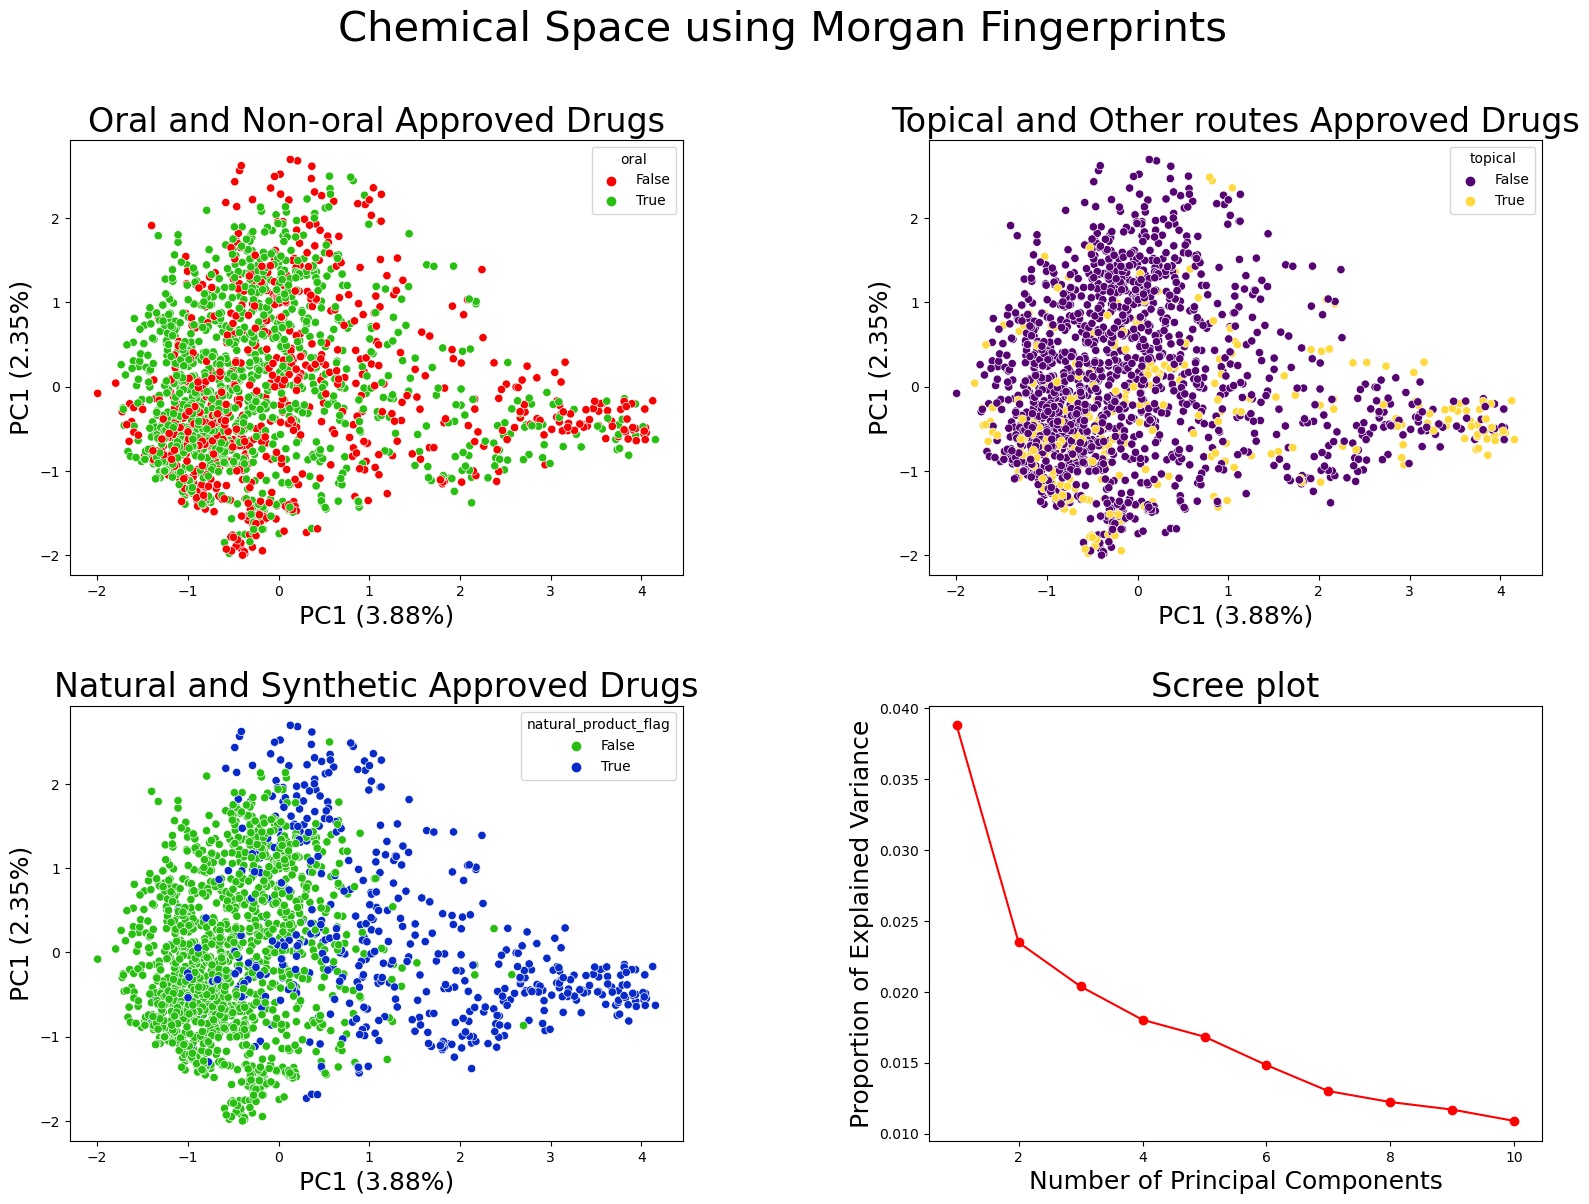

In [62]:
VAR_PC1 = round(list(pca.explained_variance_ratio_)[0]*100,2)
VAR_PC2 = round(list(pca.explained_variance_ratio_)[1]*100,2)
TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
n_rows, n_cols = 2, 2
fig, axs  = plt.subplots(n_rows, n_cols, figsize=(19,13))

palettes = {
    'oral': {True: '#29bf12', False: '#f90000'},
    'natural_product_flag': {True: '#072ac8', False: '#28bf12'},
    'topical': {True: '#FFD93d', False: '#540371'},
}

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'natural_product_flag': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

for i, category in enumerate(['oral','topical','natural_product_flag']):
    row = i // n_cols
    col = i % n_cols
    sns.scatterplot(
        data=smiles_df, x='PC1', y='PC2', hue=category, 
        ax=axs[row][col], palette=palettes[category]
    )
    axs[row][col].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[row][col].set_xlabel(f'PC1 ({VAR_PC1}%)',fontsize=AXIS_LABEL_FONT_SIZE)
    axs[row][col].set_ylabel(f'PC1 ({VAR_PC2}%)',fontsize=AXIS_LABEL_FONT_SIZE)

PC_values = np.arange(pca.n_components_) + 1
axs[1][1].plot(PC_values, pca.explained_variance_ratio_, 'ro-')
axs[1][1].set_title('Scree plot', fontsize=TITLE_FONT_SIZE)
axs[1][1].set_xlabel('Number of Principal Components', fontsize=AXIS_LABEL_FONT_SIZE)
axs[1][1].set_ylabel('Proportion of Explained Variance', fontsize=AXIS_LABEL_FONT_SIZE)


fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.suptitle('Chemical Space using Morgan Fingerprints', fontsize=30)

## t-Distributed Stochastic Neighbour Embbed

In [63]:
model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=7000)
tsne_drugs = model.fit_transform(X_morgan)

In [64]:
smiles_df['TSNE_C1'] = tsne_drugs.T[0]
smiles_df['TSNE_C2'] = tsne_drugs.T[1]

Text(0.5, 0.98, 'Chemical Space Visualization of FDA Approved Drugs \n(Morgan Fingerprints)')

<Figure size 640x480 with 0 Axes>

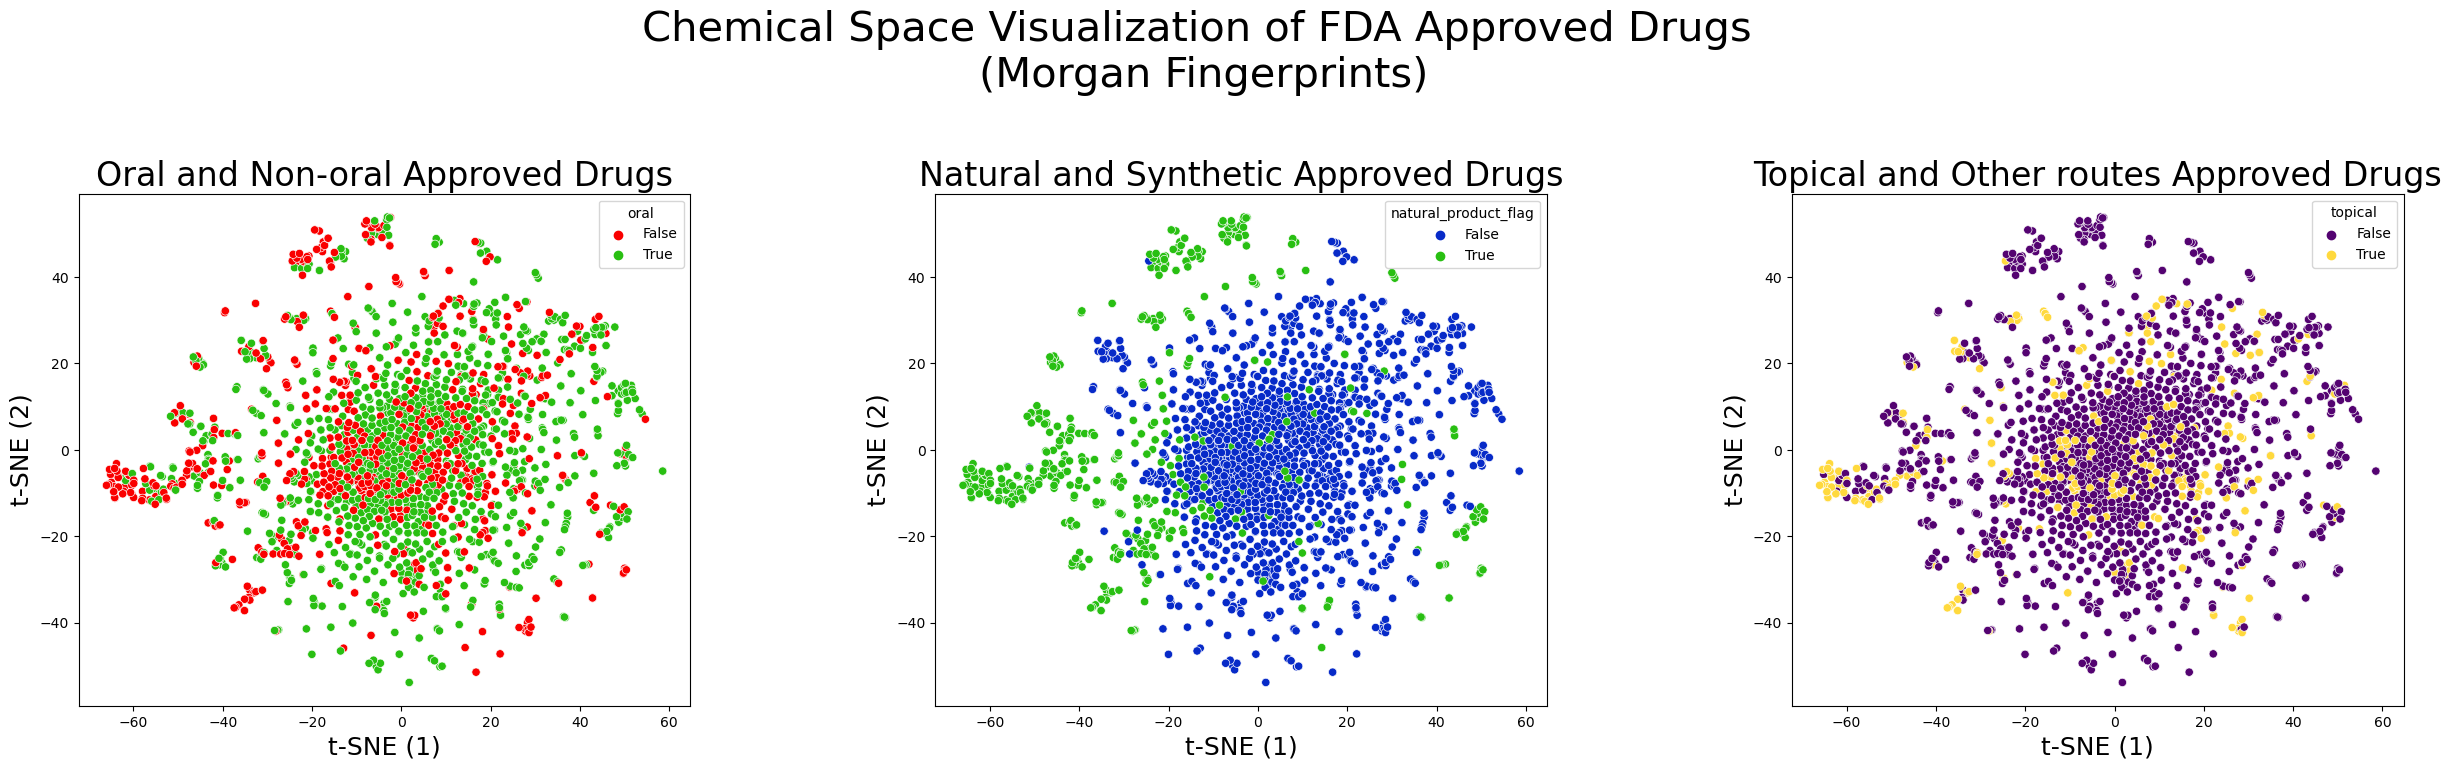

In [72]:
# t-SNE plots for oral/non-oral, natural/synthtetic, topical/other

TITLE_FONT_SIZE = 24
AXIS_LABEL_FONT_SIZE = 18

plt.tight_layout()
fig, axs = plt.subplots(1,3, figsize=(30, 8))

plot_titles = {
    'oral': 'Oral and Non-oral Approved Drugs',
    'natural_product_flag': 'Natural and Synthetic Approved Drugs',
    'topical': 'Topical and Other routes Approved Drugs'
}

for i, category in enumerate(['oral', 'natural_product_flag', 'topical']):
    sns.scatterplot(
        data=smiles_df, x='TSNE_C1', y='TSNE_C2',
        hue=category, palette=palettes[category], ax=axs[i])
    axs[i].set_title(plot_titles[category], fontsize=TITLE_FONT_SIZE)
    axs[i].set_xlabel('t-SNE (1)', fontsize=AXIS_LABEL_FONT_SIZE)
    axs[i].set_ylabel('t-SNE (2)', fontsize=AXIS_LABEL_FONT_SIZE)

# Final adjustments
plt.subplots_adjust(wspace=0.4, top=0.75)
fig.suptitle('Chemical Space Visualization of FDA Approved Drugs \n(Morgan Fingerprints)', fontsize=30)